In [1]:
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import numpy as np
import pandas as pd
import keras_tuner
import gc
import cv2
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import mobilenet_v2 , resnet50

## 4 1 2 bands for near infrared
## 1 2 3 for normal rgb

2023-05-09 20:18:20.708965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 20:18:20.846649: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
tf.version.VERSION
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
##device_lib.list_local_devices()

Num GPUs Available:  2


In [111]:
import os
import glob
dirname = os.path.join(os.getcwd(), 'Data', 'PocketN_6_64')    
images_path = glob.glob(dirname + "/images/*.tif")

**Loading in Data** - Functions to load in data and preprocess

In [3]:
Pocket_images,Pocket_geo,Pocket_labels = hp.segmented_dataset_reader('PocketN_6_64')
Nuns_images, Nuns_labels = hp.segmented_dataset_reader('NunsN_6_64', train_bool=True)
Tubbs_images, Tubbs_labels = hp.segmented_dataset_reader('tubbsN_6_64', train_bool=True)

reading in 7189 images
reading in 13663 images
reading in 10142 images


In [4]:
print(Pocket_images.shape, Pocket_labels.shape)
print(Pocket_images.dtype, Pocket_labels.dtype)
print(Nuns_images.shape, Nuns_labels.shape)
print(Nuns_images.dtype, Nuns_labels.dtype)
print(Tubbs_images.shape, Tubbs_labels.shape)
print(Tubbs_images.dtype, Tubbs_labels.dtype)

(7189, 128, 128, 3) (7189, 128, 128)
float32 uint8
(13663, 128, 128, 3) (13663, 128, 128)
float32 uint8
(10142, 128, 128, 3) (10142, 128, 128)
float32 uint8


In [102]:
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      1, 2645655, 2420751, 1802745, 1212100,  865902, 2816558]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([       2,  1405556,  2566197,  2525991,  2082224,  1792344,
       12008230]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      3, 1636514, 2603359, 1678029, 1207479, 1293314, 8194678]))


In [4]:
Pocket_labels = np.where(Pocket_labels == 0, Pocket_labels + 1, Pocket_labels) - 1
Nuns_labels = np.where(Nuns_labels == 0, Nuns_labels + 1, Nuns_labels) - 1
Tubbs_labels = np.where(Tubbs_labels == 0, Tubbs_labels + 1, Tubbs_labels) - 1

In [5]:
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([26752216, 24112194, 17624199, 11158479,  8881664, 29255824]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 15240376,  26102818,  24247211,  18907182,  17616009, 121740996]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([16721695, 25556290, 16293345, 11829351, 12645205, 83120642]))


**Displaying images and labels**

0.61960787 0.043137256
float32
(128, 128, 3)


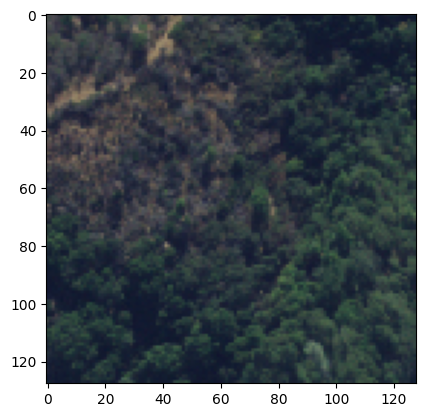

In [7]:
img = Pocket_images[500]/255.0
print(img.max(), img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img, vmax=1, vmin=0)

(128, 128)
[0 1 3 4 5]
5 0
uint8


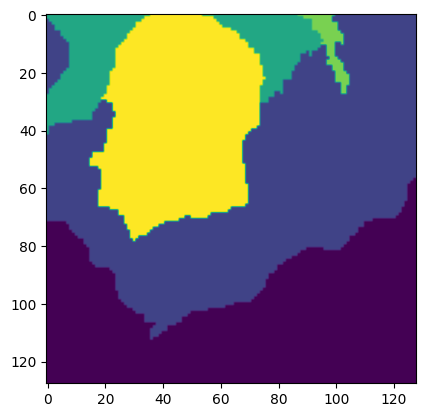

In [8]:
lbl = Pocket_labels[500]
print(lbl.shape)
print(np.unique(lbl))
print(lbl.max(), lbl.min())
print(lbl.dtype)
plt.imshow(lbl)

**Creating training and testing datasets** - creating the training and testing datasets and generating class weights

In [7]:
train_images = np.concatenate((Pocket_images, Tubbs_images), axis=0)
train_labels = np.concatenate((Pocket_labels, Tubbs_labels), axis=0)
test_images = Nuns_images
test_labels = Nuns_labels

In [8]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(train_labels.flatten()), y = train_labels.flatten())
print(class_weights)

[1.08858814 0.95282119 1.39530103 2.05870602 2.19842393 0.42113074]


In [10]:
del Pocket_images
del Pocket_labels
del Nuns_images
del Nuns_labels
del Tubbs_images
del Tubbs_labels

In [13]:
print(train_images.shape, train_labels.shape)
print(train_images.dtype, train_labels.dtype)
print(train_images.max(),train_images.min())
print(np.unique(train_labels, return_counts=True))
print(test_images.shape, test_labels.shape)
print(test_images.dtype, test_labels.dtype)

(17331, 128, 128, 3) (17331, 128, 128)
float32 uint8
229.0 4.0
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 43473911,  49668484,  33917544,  22987830,  21526869, 112376466]))
(13663, 128, 128, 3) (13663, 128, 128)
float32 uint8


In [14]:
# Creating alias for leaky_relu
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'leaky_relu': keras.layers.LeakyReLU()})

In [15]:
#All my callback are called here
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
_callbacks = [r_lr, e_stop]
gc.collect()

1686

**Hyper parameter optimization** - hyperparameter optimzation using keras tuner

In [13]:
#simple unet keras tuner builder
def build_Unet(hpf): 
        model = hp.build_unet_model(6,act='elu', drop=0.3, drop2=0.2,
                                drop_bool=True, drop_bool2=False,
                                filter=48, act2='leaky_relu', gamma=1, lr=0.003, opt='adam')
        return model


In [14]:
#keras_tuner hyperband object
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

2023-04-19 10:13:32.040818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-04-19 10:13:32.041036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9450 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [16]:
#performs hyper parameter optimization
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 30 Complete [00h 04m 08s]
val_mean_io_u: 0.337273508310318

Best val_mean_io_u So Far: 0.337273508310318
Total elapsed time: 01h 36m 08s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in hp_results/canopy_fire
Showing 10 best trials
Objective(name="val_mean_io_u", direction="max")

Trial 29 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.002280979101947618
Score: 0.337273508310318

Trial 17 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.004058869337820706
Score: 0.333394855260849

Trial 18 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.0038974298555901656
Score: 0.3323601186275482

Trial 21 summary
Hyperparameters:
filters: 32
activation2: leaky_relu
gamma: 1
lr: 0.005242356927402547
Score: 0.33228087425231934

Trial 04 summary
Hyperparameters:
filters: 48
activation2: relu
gamma: 2
lr: 0.004711734276857738
Score: 0.3262912929058075

Trial 11 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 2
lr: 0.004672024591090819
Score: 0.325443834066391

Trial 14 summary
Hyperparameters:
filters: 16
activation2: leaky_relu
gamma: 1
lr: 0.0042356479569

In [18]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.002280979101947618}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.004058869337820706}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0038974298555901656}, {'filters': 32, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.005242356927402547}, {'filters': 48, 'activation2': 'relu', 'gamma': 2, 'lr': 0.004711734276857738}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 2, 'lr': 0.004672024591090819}, {'filters': 16, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0042356479569323905}, {'filters': 32, 'activation2': 'relu', 'gamma': 2, 'lr': 0.0044862339105765}, {'filters': 16, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0021387126805189095}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.003082818673647337}]


In [19]:
df = pd.DataFrame(mylist)
df

,filters,activation2,gamma,lr
0,48,leaky_relu,1,0.002281
1,48,leaky_relu,1,0.004059
2,48,leaky_relu,1,0.003897
3,32,leaky_relu,1,0.005242
4,48,relu,2,0.004712
5,48,leaky_relu,2,0.004672
6,16,leaky_relu,1,0.004236
7,32,relu,2,0.004486
8,16,leaky_relu,1,0.002139
9,48,leaky_relu,1,0.003083


**optimized simple unet fitting**

In [16]:
model = hp.build_unet_model(num_class = 6, weights = class_weights, act2='leaky_relu')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 48  219        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 48  2784       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [18]:
gc.collect()

0

In [19]:
history = model.fit(train_images/255.0, train_labels, epochs=50, validation_data=(test_images/255.0, test_labels), batch_size=16, callbacks = _callbacks, shuffle=True)  #beat 0.3770 #beat 0.3314

Epoch 1/50


In [14]:
model.save('Models/simple_seg_model_full_6class_PocketTubbs.tf', overwrite=True)
# model= keras.models.load_model("simple_seg_model.h5")

INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_NunsTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_NunsTubbs.tf/assets


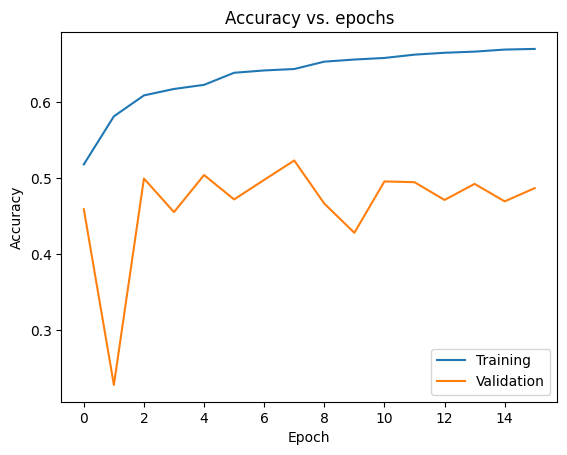

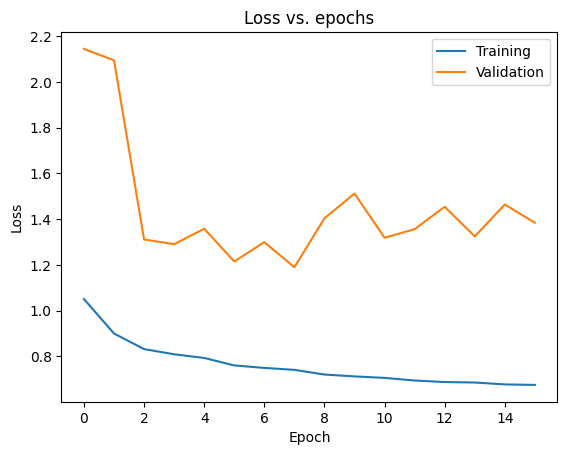

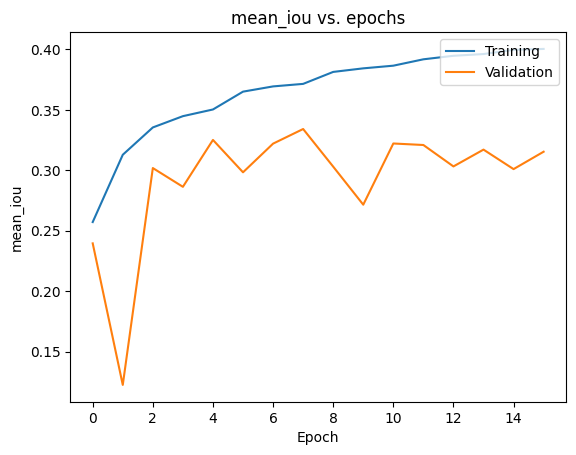

In [12]:
hp.plot_accuracy(history)
hp.plot_loss(history)
hp.plot_meaniou(history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


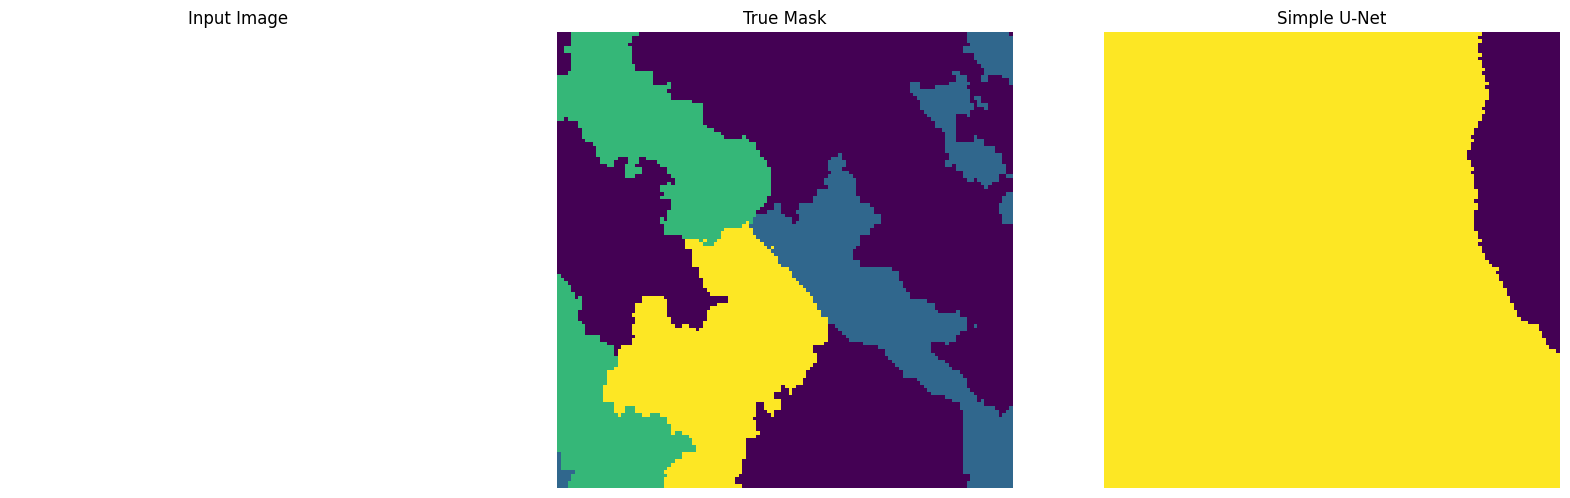

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


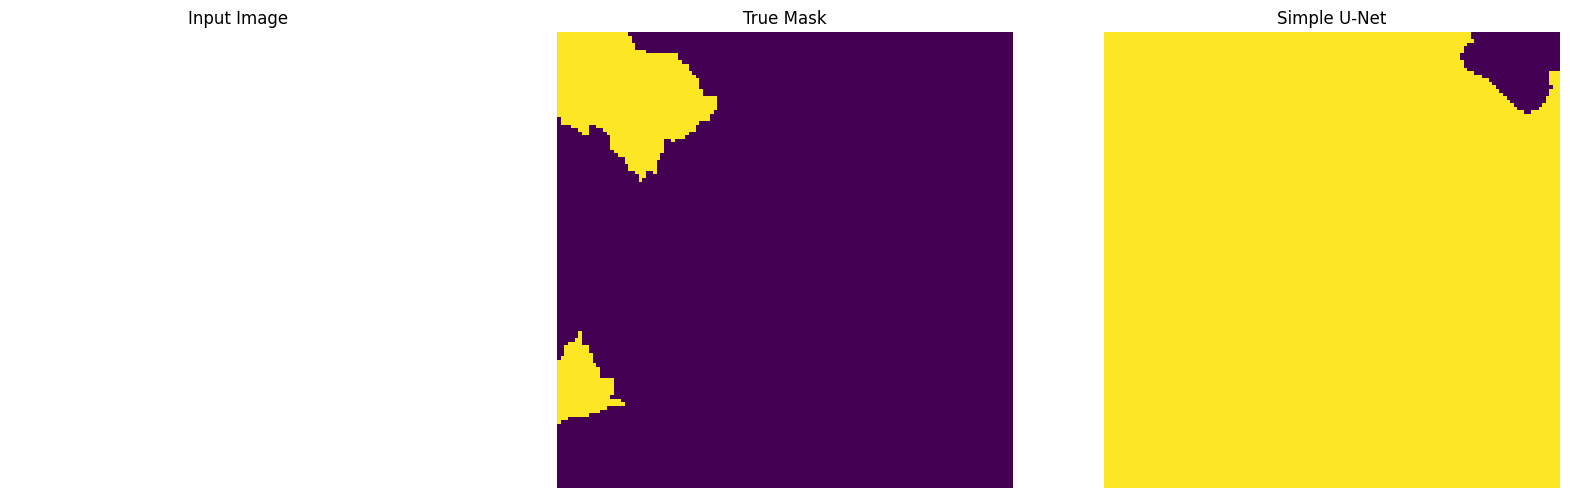

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


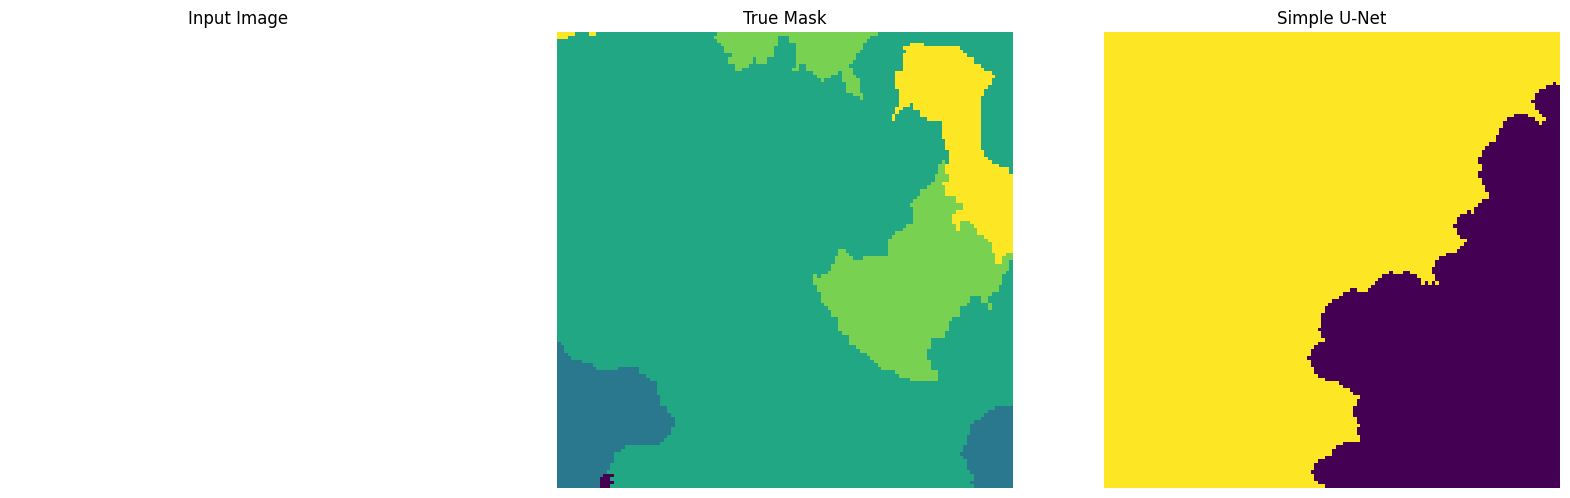

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


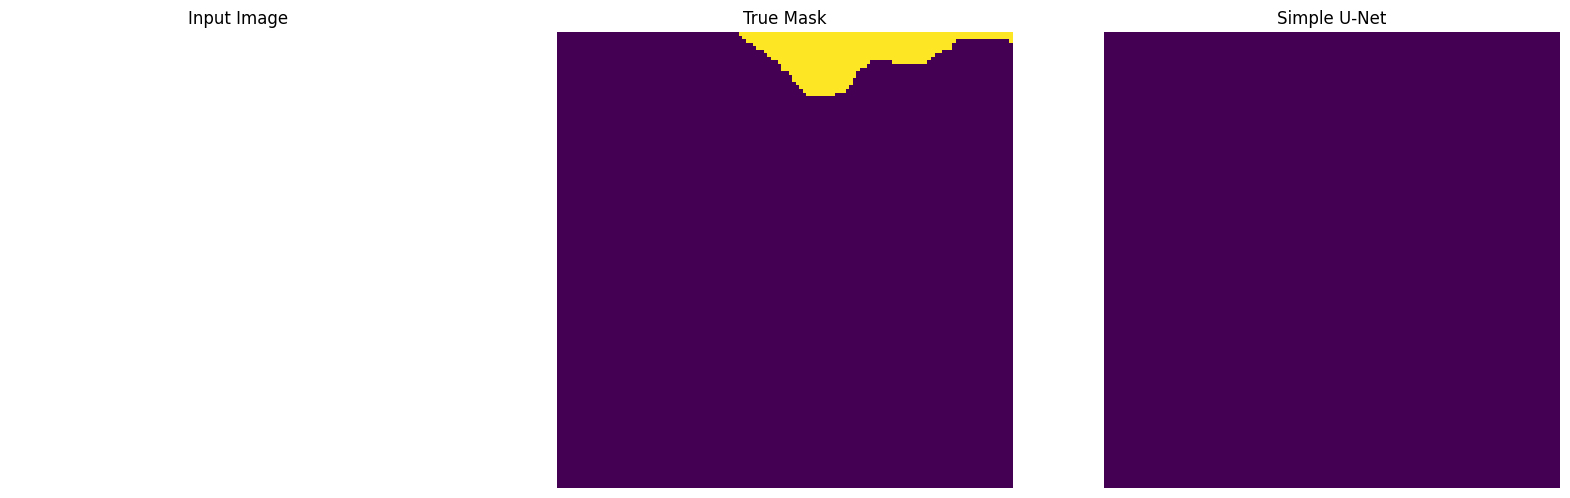

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


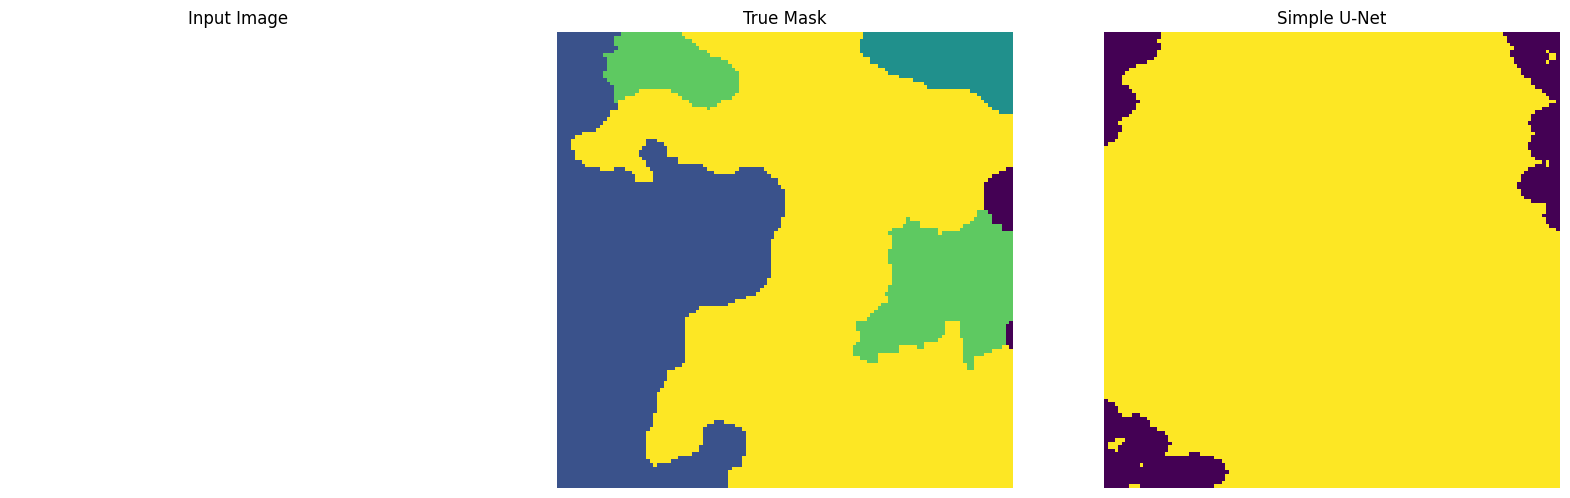

In [13]:
hp.show_predictions(model, test_images[100:105], test_labels[100:105], 5, "Simple U-Net")
#del model

**Hyper Parameter optimization of mobile Unet** - using keras tuner and hyperband


In [9]:
def build_Mobile_Unet(hpf):
        model = hp.mobile_unet_model(6, trainable = 2, batch_bool = True, opt = 'adam', lr = 0.004, gamma = 1)
        return model

In [23]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Mobile_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

In [24]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 30 Complete [00h 01m 24s]
val_mean_io_u: 0.26924198865890503

Best val_mean_io_u So Far: 0.283194899559021
Total elapsed time: 00h 42m 12s
INFO:tensorflow:Oracle triggered exit


In [25]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'training layers': 2, 'lr': 0.00454075841255362}, {'training layers': 2, 'lr': 0.005490222637767316}, {'training layers': 2, 'lr': 0.004242922659531865}, {'training layers': 2, 'lr': 0.005773107053690844}, {'training layers': 2, 'lr': 0.0031312733259334018}, {'training layers': 5, 'lr': 0.0034807827859902126}, {'training layers': 2, 'lr': 0.005706033148428903}, {'training layers': 3, 'lr': 0.005498696508094774}, {'training layers': 2, 'lr': 0.0035225490910381625}, {'training layers': 3, 'lr': 0.0038647162039910287}]


In [26]:
df = pd.DataFrame(mylist)
df

,training layers,lr
0,2,0.004541
1,2,0.005490
2,2,0.004243
3,2,0.005773
4,2,0.003131
5,5,0.003481
6,2,0.005706
7,3,0.005499
8,2,0.003523
9,3,0.003865


**Fitting the optimized mobile Unet**

In [10]:
keras.backend.clear_session()
model_mobile = hp.mobile_unet_model(output_channels=6, weights=class_weights)
model_mobile.summary()
gc.collect()

2023-05-09 15:56:45.725678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 15:56:46.513562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-09 15:56:46.514200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9445 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_1[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

7067

In [11]:
gc.collect()


0

In [12]:
history_mobile = model_mobile.fit(mobilenet_v2.preprocess_input(train_images), train_labels, epochs=50, batch_size=32,
                                  validation_data=(mobilenet_v2.preprocess_input(test_images), test_labels),
                                  callbacks=_callbacks, shuffle=True)  #.3175

Epoch 1/50


2023-05-09 15:56:59.309552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


744/744 [==============================] - 43s 53ms/step - loss: 1.0949 - accuracy: 0.5152 - mean_io_u: 0.2520 - val_loss: 1.6367 - val_accuracy: 0.4245 - val_mean_io_u: 0.2419 - lr: 0.0040
Epoch 2/50
744/744 [==============================] - 36s 49ms/step - loss: 1.0220 - accuracy: 0.5387 - mean_io_u: 0.2737 - val_loss: 1.6033 - val_accuracy: 0.4068 - val_mean_io_u: 0.2170 - lr: 0.0040
Epoch 3/50
744/744 [==============================] - 37s 49ms/step - loss: 0.9905 - accuracy: 0.5499 - mean_io_u: 0.2832 - val_loss: 1.7360 - val_accuracy: 0.3382 - val_mean_io_u: 0.1978 - lr: 0.0040
Epoch 4/50
744/744 [==============================] - 37s 50ms/step - loss: 0.9768 - accuracy: 0.5584 - mean_io_u: 0.2889 - val_loss: 1.5475 - val_accuracy: 0.4497 - val_mean_io_u: 0.2502 - lr: 0.0040
Epoch 5/50
744/744 [==============================] - 37s 50ms/step - loss: 0.9606 - accuracy: 0.5628 - mean_io_u: 0.2934 - val_loss: 1.6673 - val_accuracy: 0.4045 - val_mean_io_u: 0.2125 - lr: 0.0040
Epoch 

In [65]:
#model_mobile = keras.models.load_model("mobilenet_seg_model_full.tf")

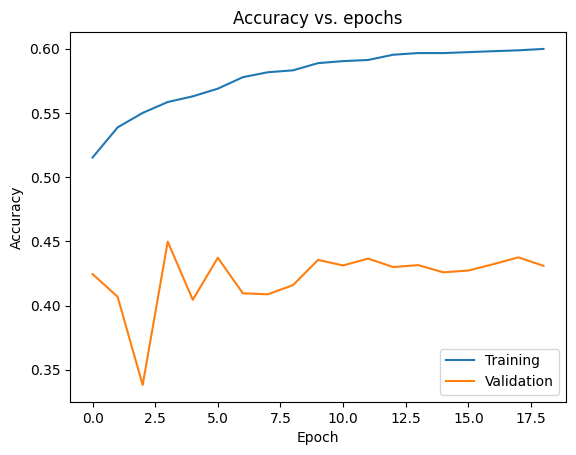

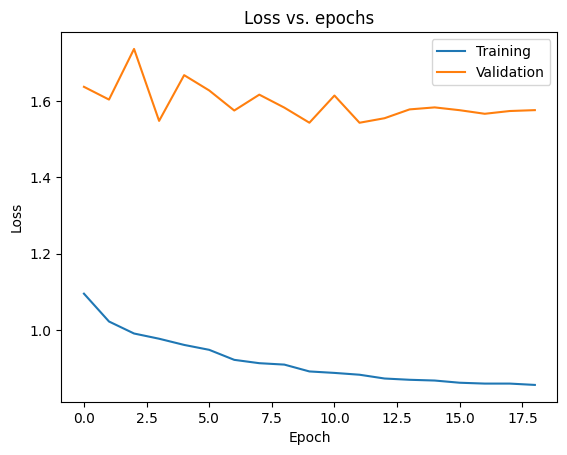

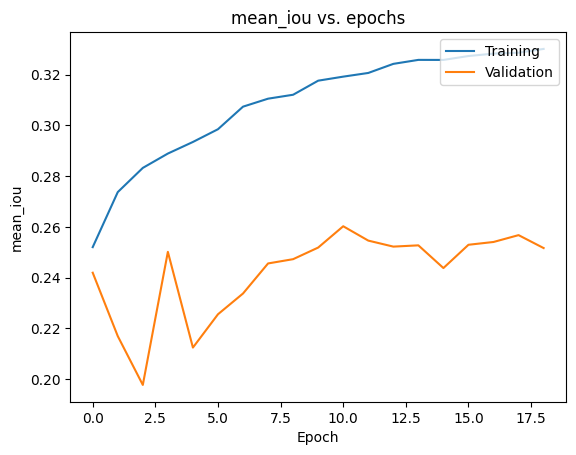

In [13]:
hp.plot_accuracy(history_mobile)
hp.plot_loss(history_mobile)
hp.plot_meaniou(history_mobile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


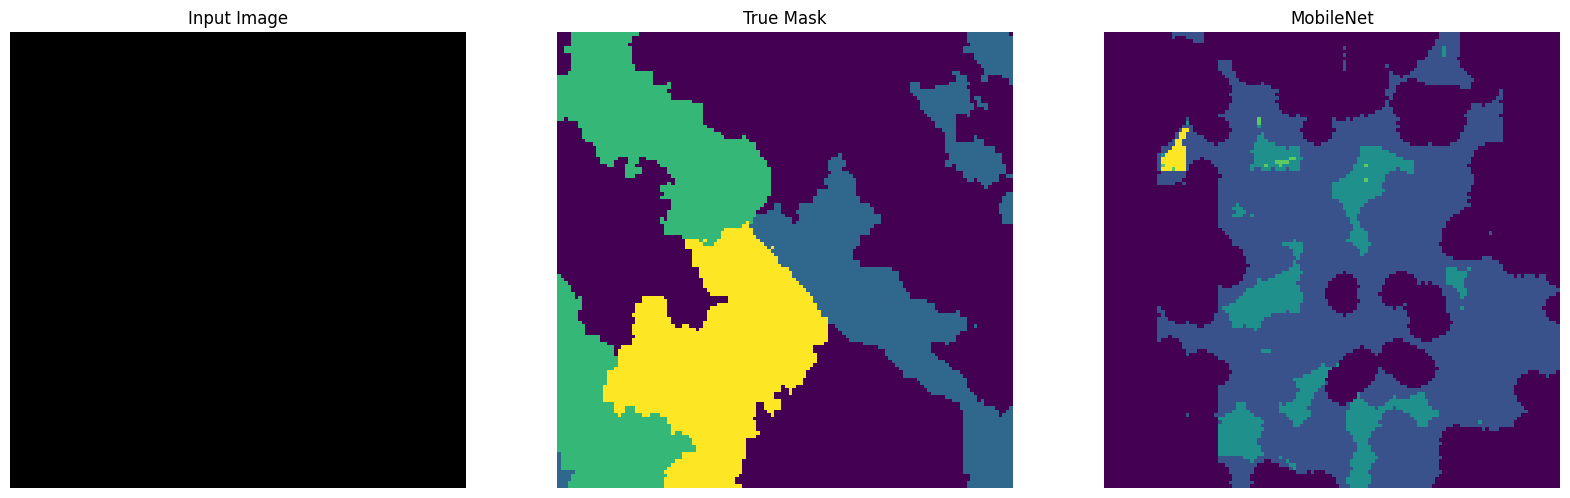

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


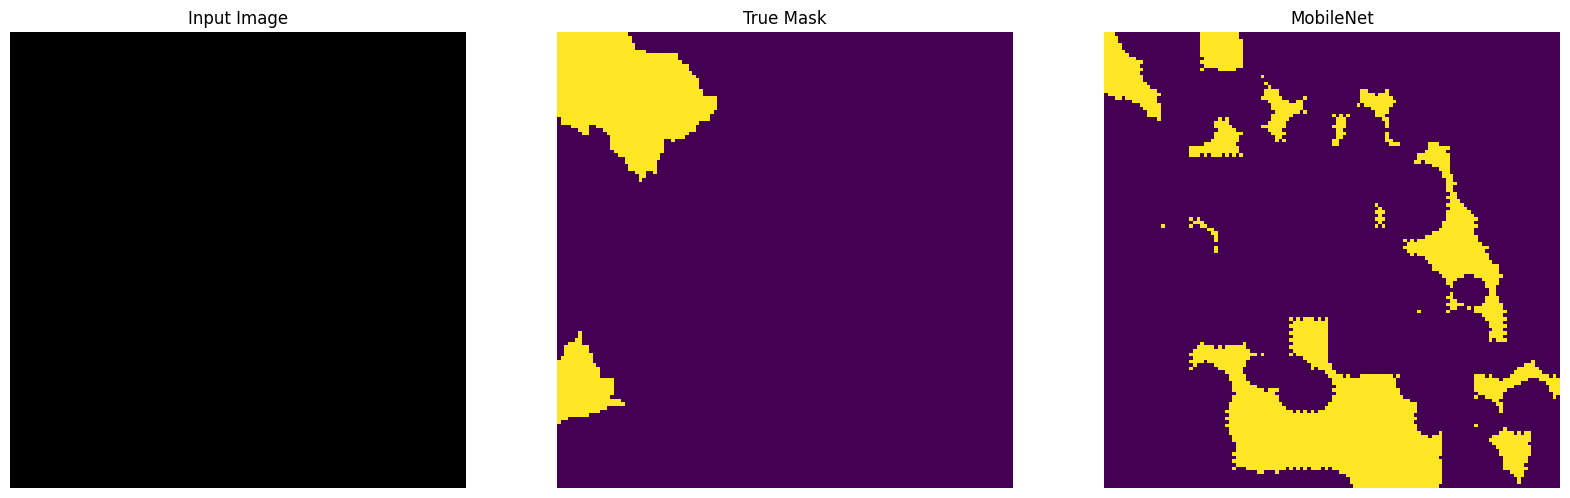

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


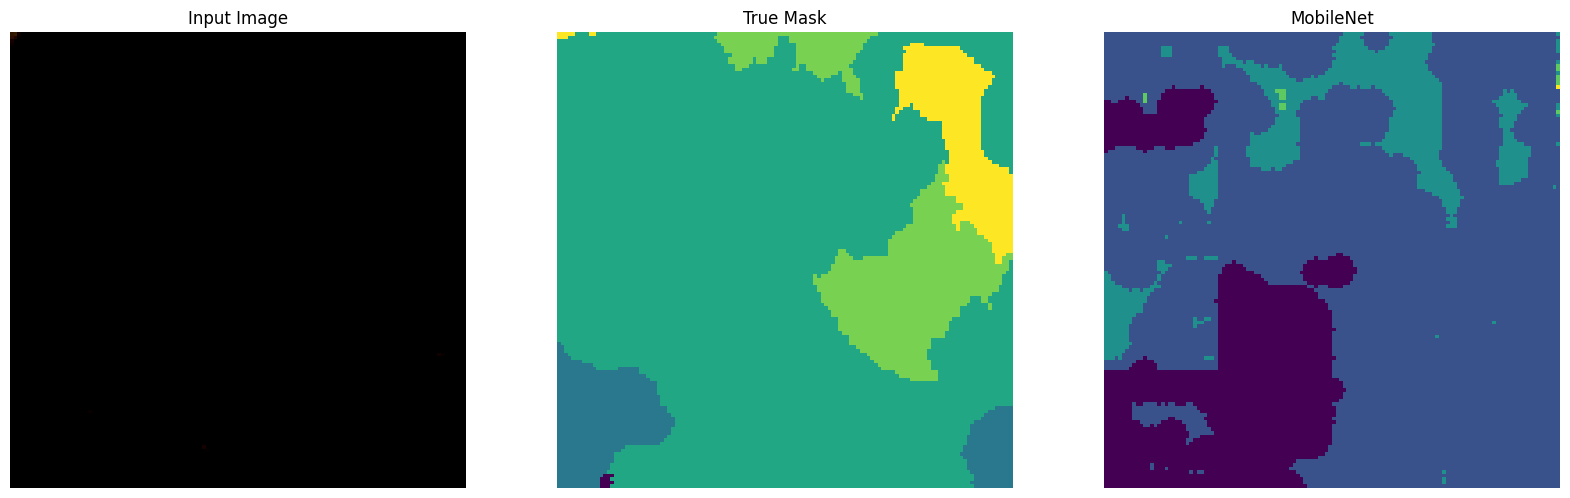

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


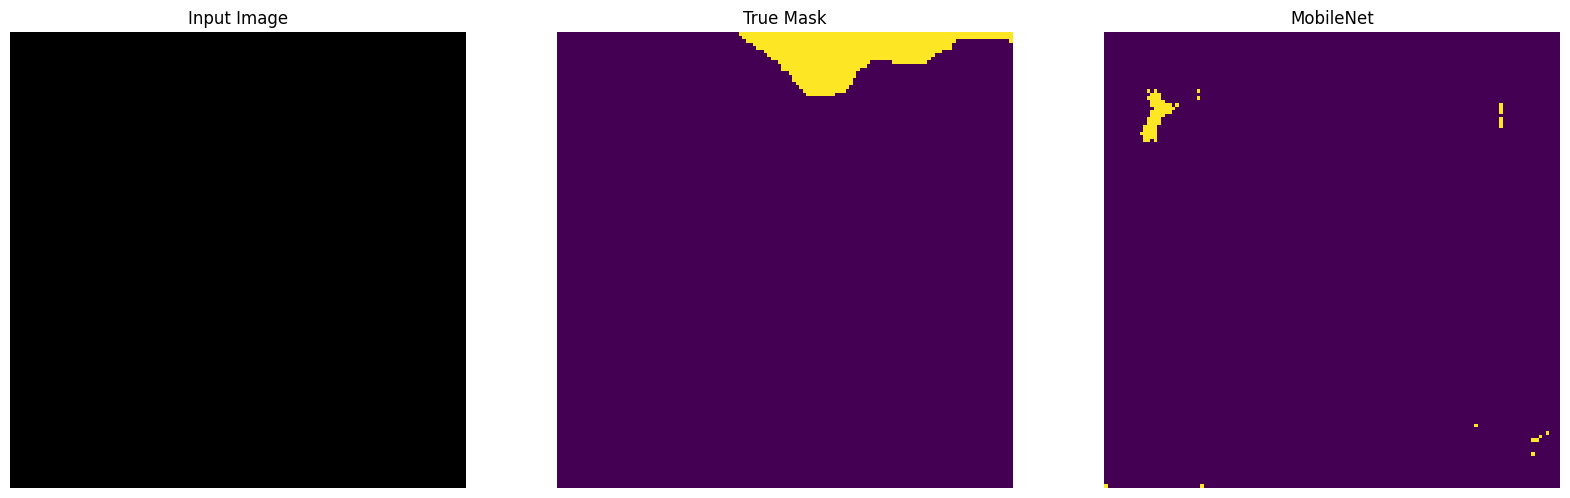

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


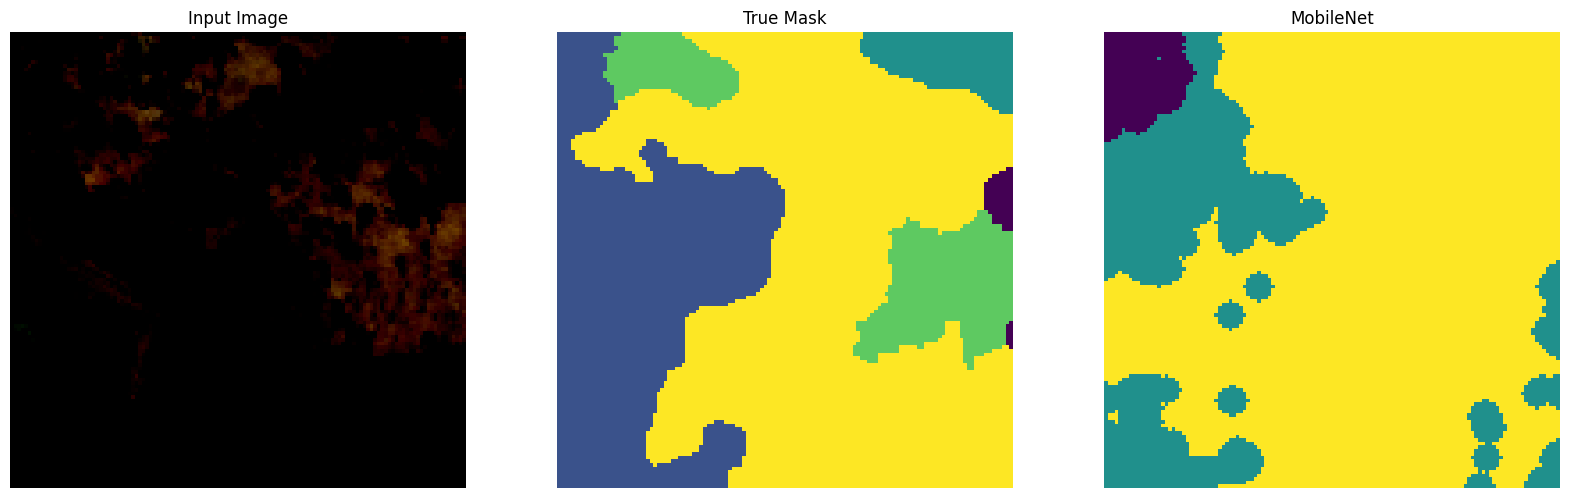

In [14]:
hp.show_predictions(model_mobile, test_images[100:105], test_labels[100:105], 5, "MobileNet")

In [15]:
model_mobile.save('Models/mobilenet_seg_model_full_6class_PocketTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: Models/mobilenet_seg_model_full_6class_NunsTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/mobilenet_seg_model_full_6class_NunsTubbs.tf/assets


**Setting up deeplab keras tuner**


In [9]:
def build_Deeplab_Unet(hpf):
        _drop_rate = hpf.Choice("drop_rate",[0.1,0.3,0.4])
        _drop_rate2 = hpf.Choice("drop_rate2",[0.1,0.2,0.3,0.4])
        _batch_bool = hpf.Boolean("batch_bool")
        _batch_bool2 = hpf.Boolean("batch_bool2")
        _lr = hpf.Float("lr", min_value=0.003, max_value=0.006, sampling="linear")
        _gamma = hpf.Choice("gamma", [1,2,3])
        model = hp.DeeplabV3Plus(image_size=128, num_classes=6,drop_rate= _drop_rate, drop_rate2=_drop_rate2,
                                 batch_bool= _batch_bool, batch_bool2 = _batch_bool2, opt = 'SGD', lr = _lr, gamma = _gamma)
        return model

In [10]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Deeplab_Unet,
    objective= _meaniou,
    max_trials = 20,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=False,
)

INFO:tensorflow:Reloading Tuner from hp_results/canopy_fire/tuner0.json


In [11]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 20 Complete [00h 03m 16s]
val_mean_io_u: 0.3205831050872803

Best val_mean_io_u So Far: 0.3342233896255493
Total elapsed time: 00h 19m 40s
INFO:tensorflow:Oracle triggered exit


In [11]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'drop_rate': 0.4, 'drop_rate2': 0.2, 'batch_bool': True, 'batch_bool2': True, 'lr': 0.005367958117152761, 'gamma': 1}, {'drop_rate': 0.1, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.005782724486729771, 'gamma': 1}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.0050594386264619035, 'gamma': 3}, {'drop_rate': 0.3, 'drop_rate2': 0.1, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.003941540676815267, 'gamma': 2}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003172746237806152, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.4, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003853109074008468, 'gamma': 3}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': True, 'batch_bool2': False, 'lr': 0.0033518332121181783, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.004864675432932375, 'gamma': 3}, {'drop_rate': 0.1, 'drop_ra

In [12]:
df = pd.DataFrame(mylist)
df

,drop_rate,drop_rate2,batch_bool,batch_bool2,lr,gamma
0,0.4,0.2,True,True,0.005368,1
1,0.1,0.3,False,False,0.005783,1
2,0.3,0.3,False,False,0.005059,3
3,0.3,0.1,False,False,0.003942,2
4,0.4,0.3,False,True,0.003173,2
5,0.3,0.4,False,True,0.003853,3
6,0.4,0.3,True,False,0.003352,2
7,0.3,0.3,False,True,0.004865,3
8,0.1,0.3,False,False,0.003530,2
9,0.1,0.4,False,True,0.004225,2


In [8]:
keras.backend.clear_session()
model_deeplab = hp.DeeplabV3Plus(image_size=128, num_classes=6, weight=class_weights)
model_deeplab.summary()
gc.collect()

2023-05-09 18:30:32.970747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 18:30:33.717617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-09 18:30:33.718305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9358 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

629

In [9]:
dlab_history = model_deeplab.fit(train_images/255.0, train_labels, epochs=50, batch_size=8,
                                 validation_data=(test_images/255.0, test_labels),
                                 callbacks=_callbacks, shuffle=True)

Epoch 1/50


2023-05-09 18:30:53.749005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-09 18:30:54.949627: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 18:30:54.949657: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 18:30:55.588645: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

2976/2976 [==============================] - 180s 58ms/step - loss: 1.1222 - accuracy: 0.5122 - mean_io_u: 0.2401 - val_loss: 5.8912 - val_accuracy: 0.2432 - val_mean_io_u: 0.0617 - lr: 0.0050
Epoch 2/50
2976/2976 [==============================] - 170s 57ms/step - loss: 0.9369 - accuracy: 0.5722 - mean_io_u: 0.2987 - val_loss: 1.7518 - val_accuracy: 0.3265 - val_mean_io_u: 0.1859 - lr: 0.0050
Epoch 3/50
2976/2976 [==============================] - 170s 57ms/step - loss: 0.8884 - accuracy: 0.5900 - mean_io_u: 0.3165 - val_loss: 1.3662 - val_accuracy: 0.4588 - val_mean_io_u: 0.2518 - lr: 0.0050
Epoch 4/50
2975/2976 [============================>.] - ETA: 0s - loss: 0.8498 - accuracy: 0.6046 - mean_io_u: 0.3308
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
2976/2976 [==============================] - 170s 57ms/step - loss: 0.8498 - accuracy: 0.6046 - mean_io_u: 0.3309 - val_loss: 1.3150 - val_accuracy: 0.4252 - val_mean_io_u: 0.2521 - lr: 0.0050
Epoch 5/50
2

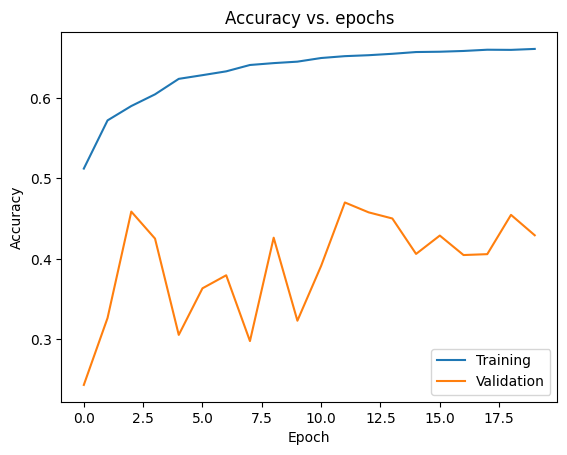

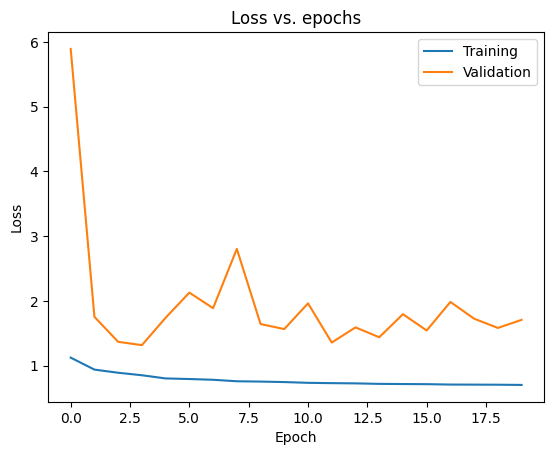

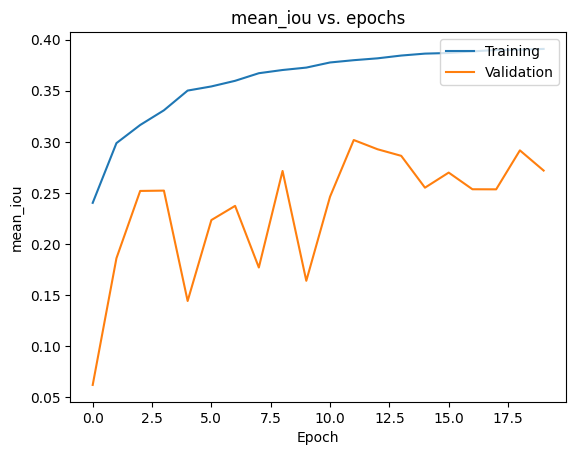

In [10]:
hp.plot_accuracy(dlab_history)
hp.plot_loss(dlab_history)
hp.plot_meaniou(dlab_history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


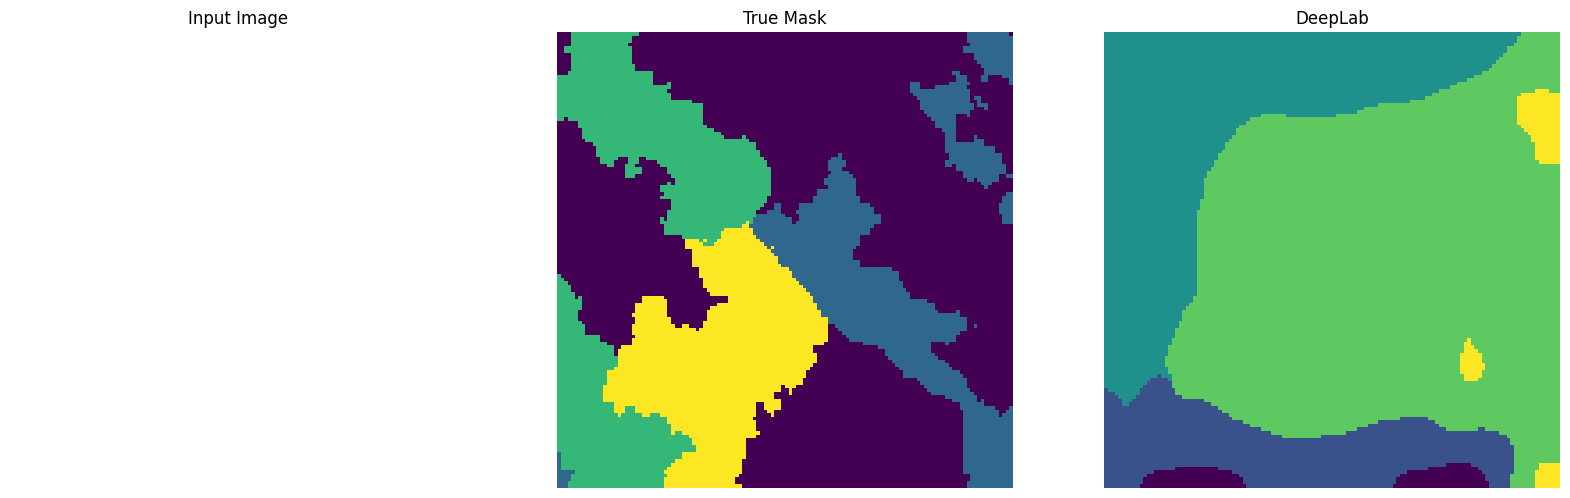

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


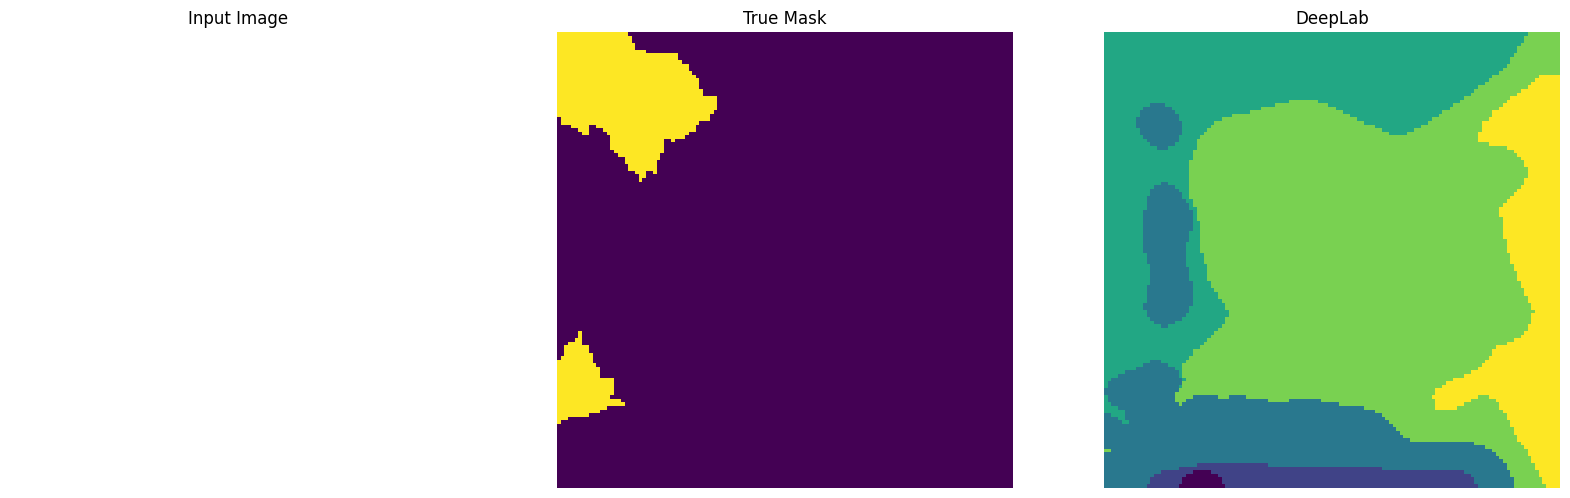

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


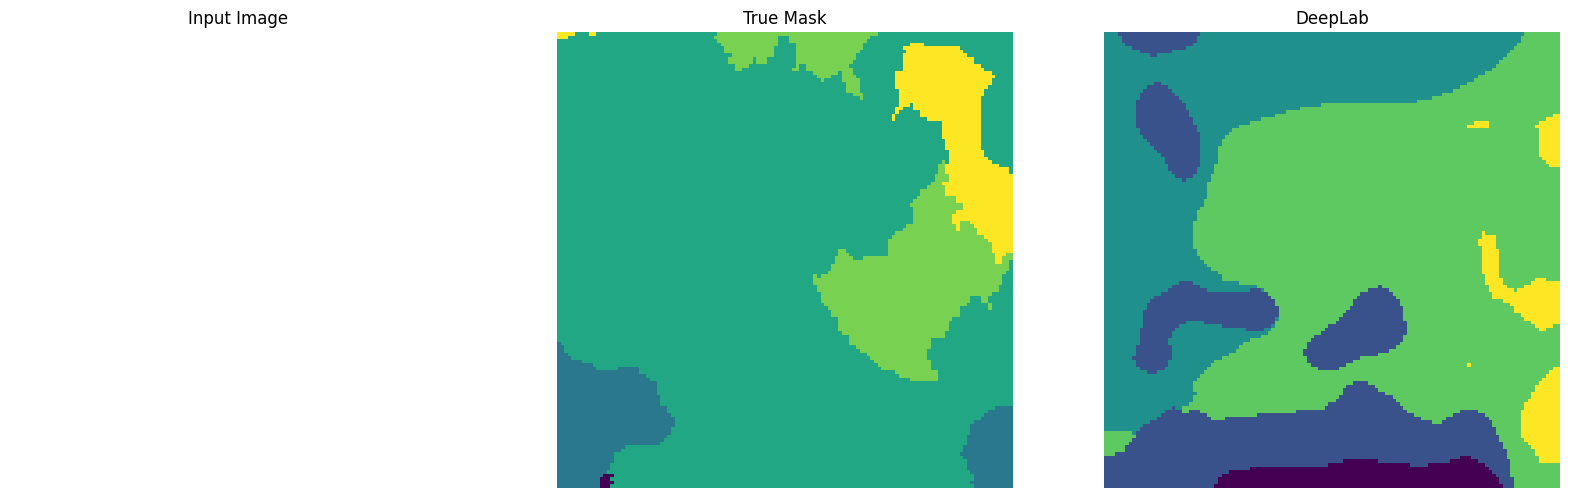

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


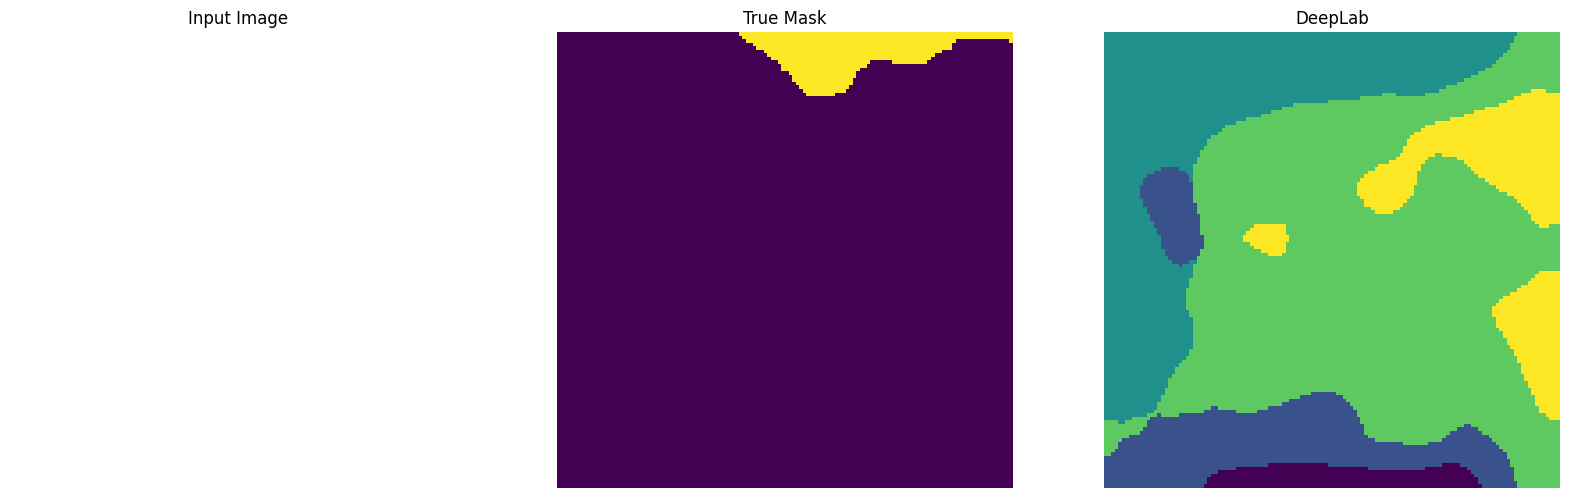

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


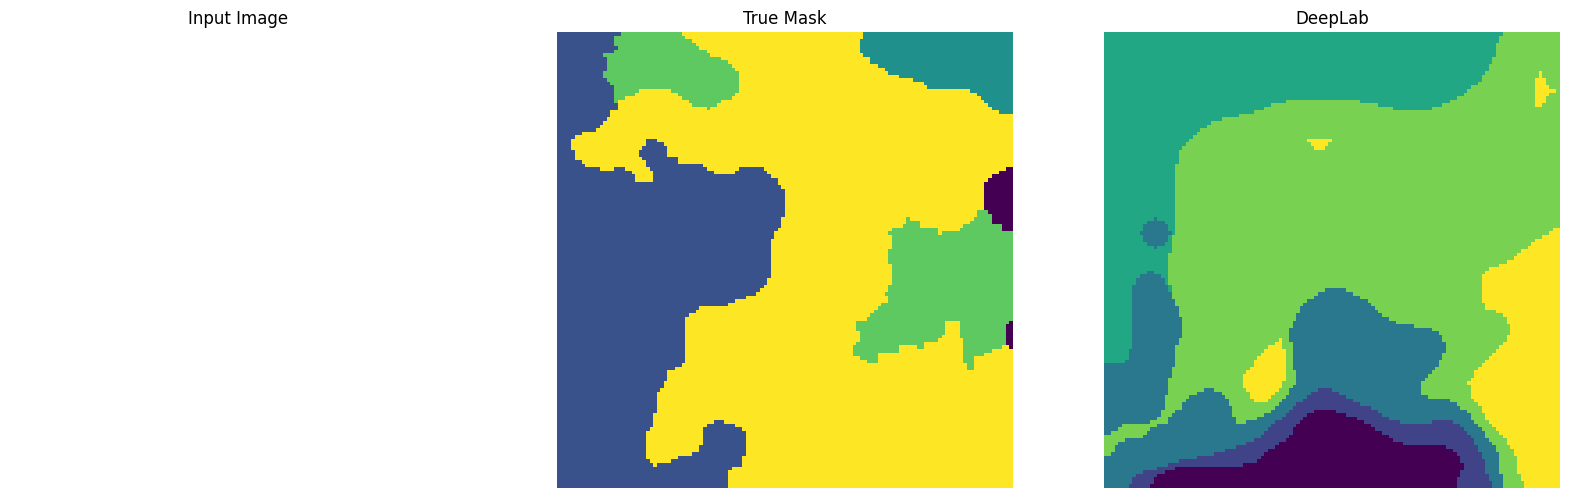

In [11]:
hp.show_predictions(model_deeplab, test_images[100:105], test_labels[100:105], 5, "DeepLab")

In [12]:
model_deeplab.save('Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf/assets


In [6]:
gc.collect()
svote_mask_tubbs = hp.voting(['deeplabv3_seg_model_full_6class_PocketNuns.tf',
                        'mobilenet_seg_model_full_6class_PocketNuns.tf',
                        'simple_seg_model_full_6class_PocketNuns.tf'],
                       Tubbs_images, Tubbs_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketNuns.tf
s_voting
0.33018968


2023-05-09 20:19:44.468269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 20:19:45.265071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-09 20:19:45.265714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9457 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf


2023-05-09 20:19:53.342632: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-09 20:20:02.579437: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 20:20:02.579465: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Models/mobilenet_seg_model_full_6class_NunsTubbs.tf
Models/simple_seg_model_full_6class_NunsTubbs.tf
s_votingcomplete: 99%
0.33337936


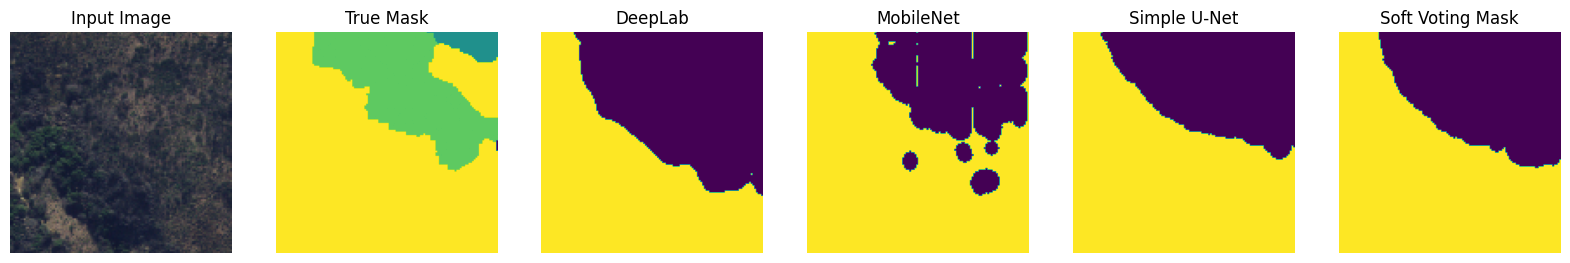

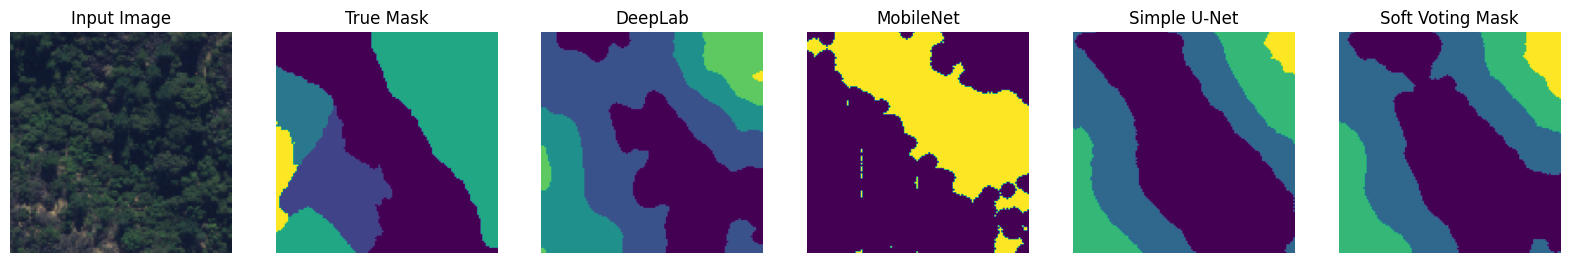

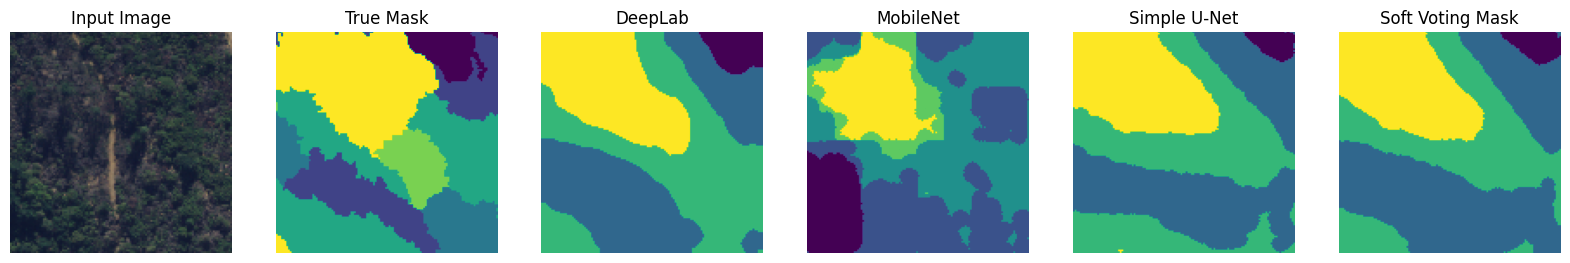

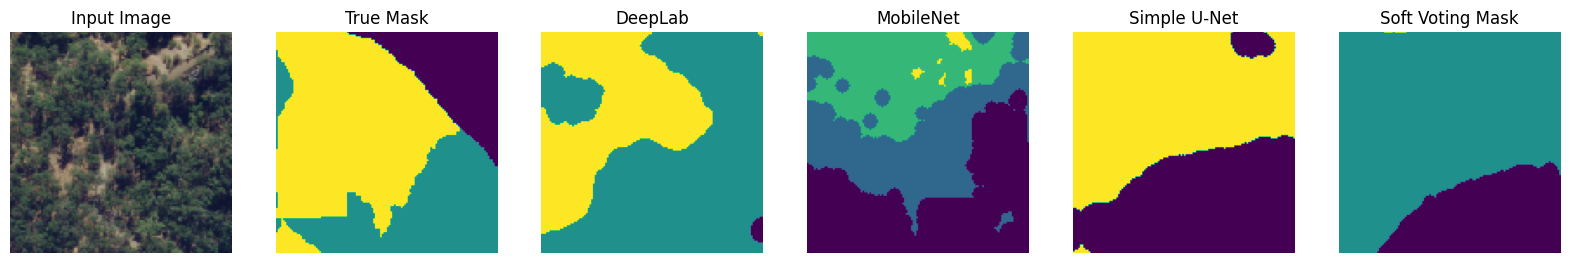

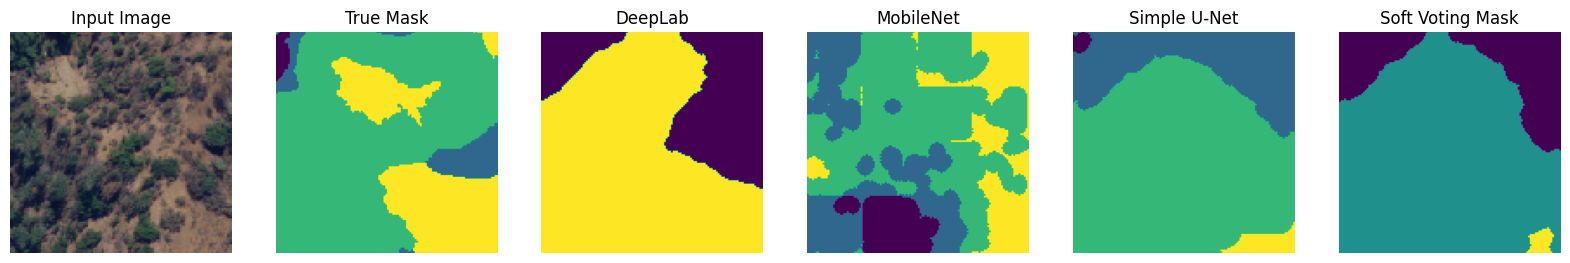

In [6]:
gc.collect()
svote_mask_Pocket = hp.voting(['Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_NunsTubbs.tf',
                        'Models/simple_seg_model_full_6class_NunsTubbs.tf'],
                       Pocket_images, Pocket_labels, offset=25, num=5)

Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf
Models/mobilenet_seg_model_full_6class_PocketTubbs.tf
Models/simple_seg_model_full_6class_PocketTubbs.tf
s_voting
0.0359116


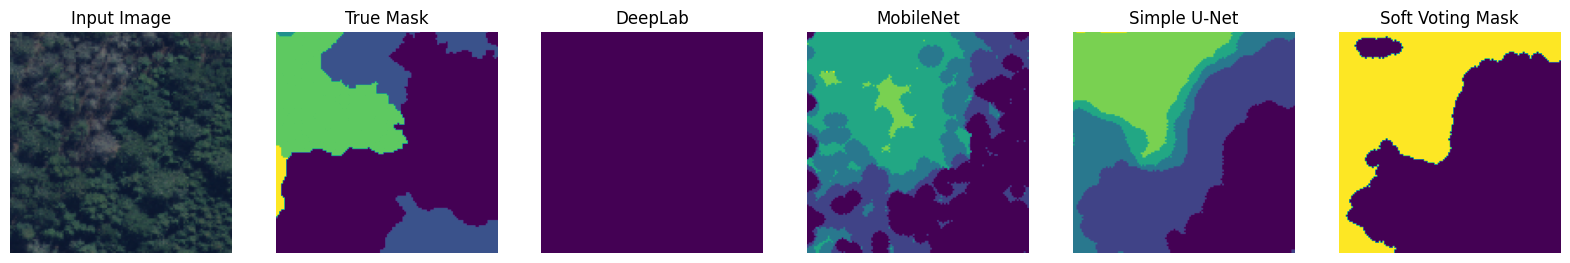

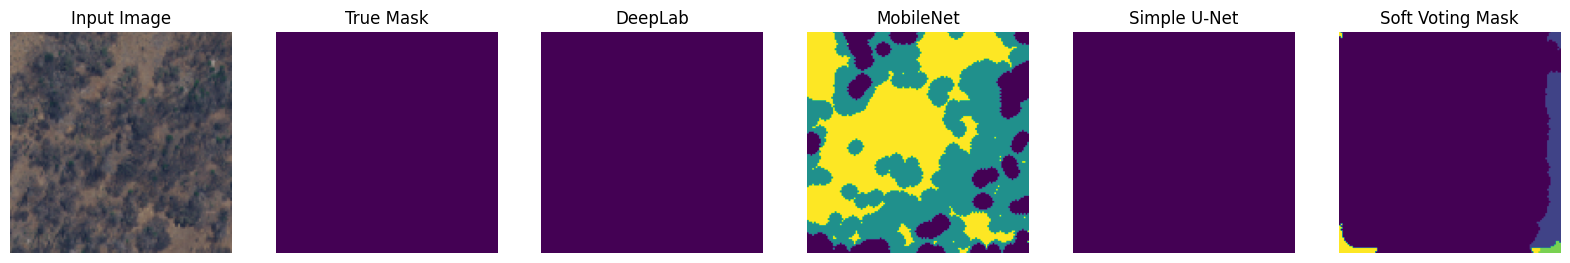

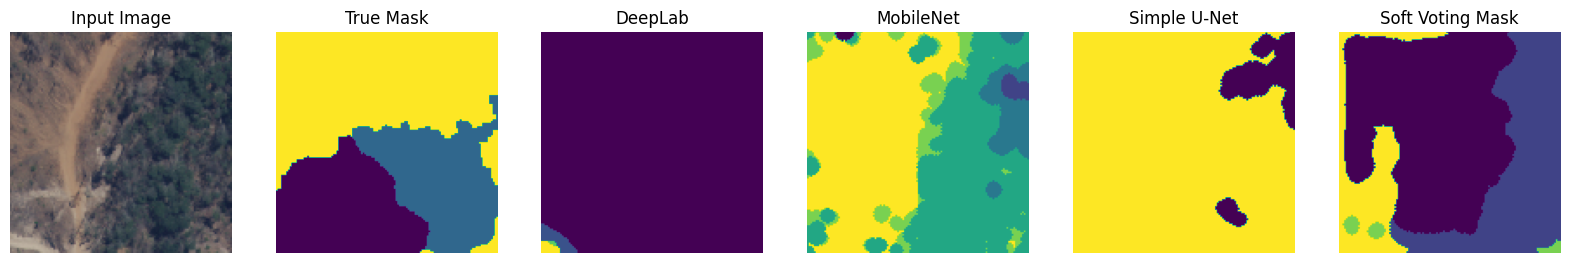

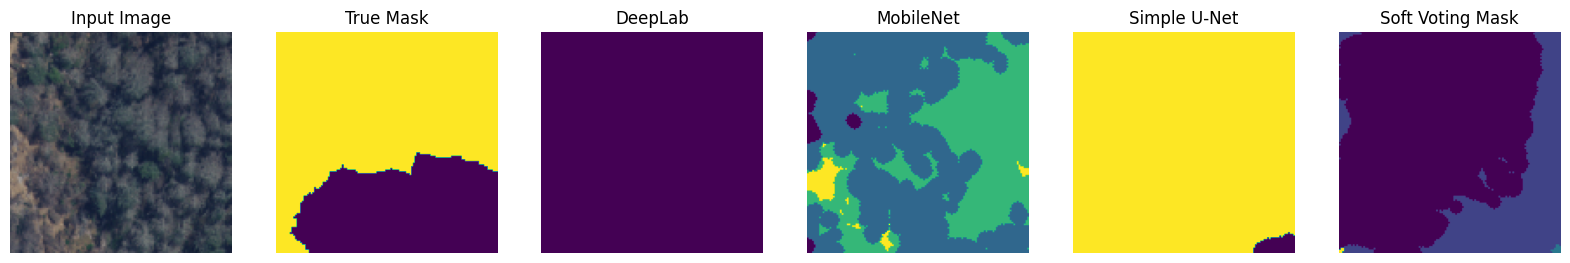

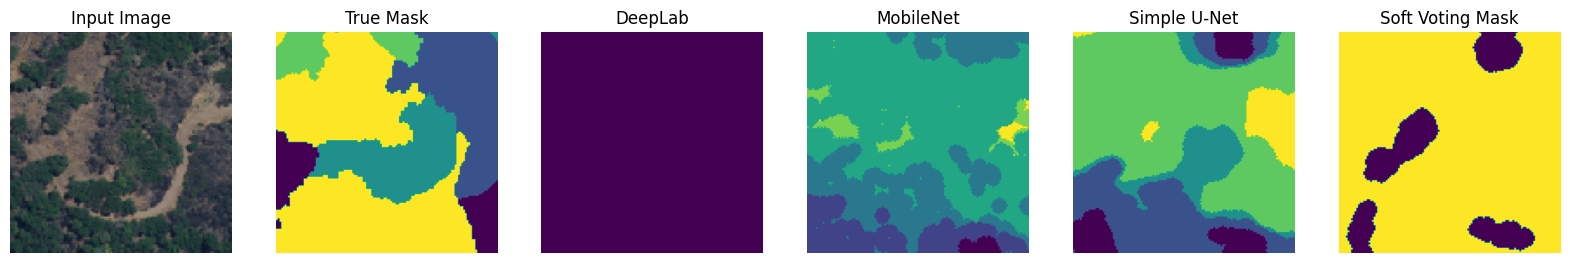

In [108]:
gc.collect()
svote_mask_Nuns = hp.voting(['Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_PocketTubbs.tf',
                         'Models/simple_seg_model_full_6class_PocketTubbs.tf'],
                       Nuns_images, Nuns_labels, offset=25, num=5)

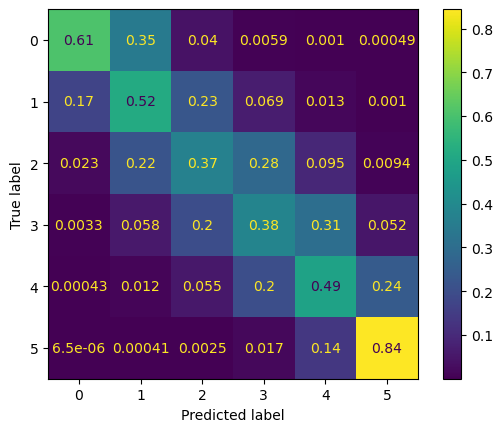

In [9]:
flat_preds = np.concatenate(svote_mask_tubbs).flatten()
flat_truth = np.concatenate(Tubbs_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

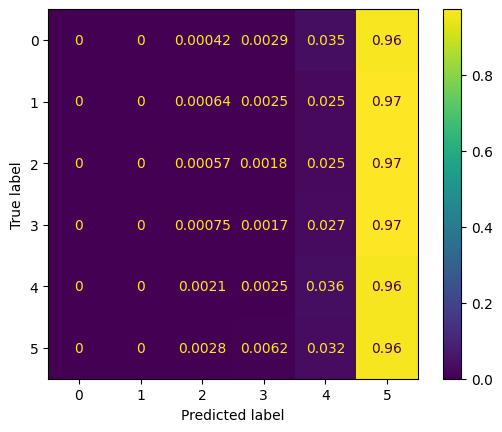

In [11]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Pocket).flatten()
flat_truth = np.concatenate(Pocket_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

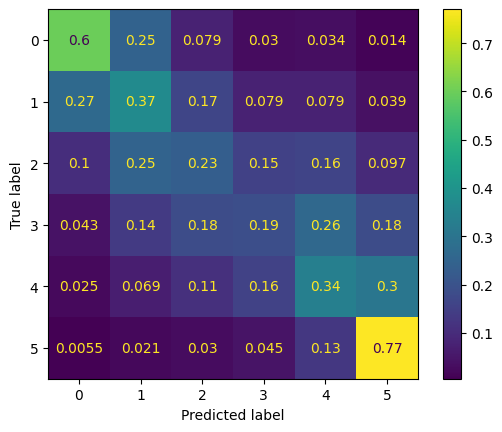

In [81]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Nuns).flatten()
flat_truth = np.concatenate(Nuns_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [12]:
#final_images = np.concatenate(Pocket_images,Tubbs_images,Nuns_images, axis =0)
final_labels = np.concatenate((Pocket_labels,Tubbs_labels,Nuns_labels), axis =0)
svote_mask_final = np.concatenate((svote_mask_Pocket,svote_mask_tubbs,svote_mask_Nuns), axis = 0)

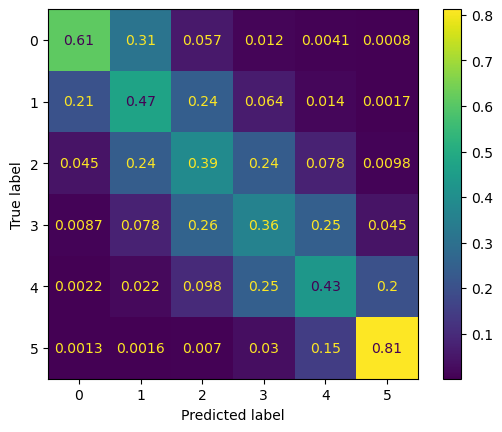

In [13]:
gc.collect()
flat_preds = np.concatenate(svote_mask_final).flatten()
flat_truth = np.concatenate(final_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [14]:
np.unique(final_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 58714287,  75771302,  58164755,  41895012,  39142878, 234117462],
       dtype=int64))

In [15]:
svote_mask_final_bin = np.copy(svote_mask_final)
final_labels_bin = np.copy(final_labels)

In [16]:
flat_preds = np.concatenate(svote_mask_final_bin).flatten()
flat_truth = np.concatenate(final_labels_bin).flatten()

In [17]:
print(np.unique(flat_preds))
print(np.unique(flat_truth))

[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [18]:
preds0 = np.where(flat_preds==0)
preds12 = np.where((flat_preds==1) | (flat_preds==2))
preds34 = np.where((flat_preds==3) | (flat_preds==4))
preds5 = np.where(flat_preds==5)

In [51]:
print(preds34)
print(preds5)
print(preds12)
print(preds0)

(array([    16444,     16445,     16446, ..., 507729404, 507729405,
       507729406], dtype=int64),)
(array([   196608,    196609,    196610, ..., 507805693, 507805694,
       507805695], dtype=int64),)
(array([        0,         1,         2, ..., 507007489, 507007491,
       507007617], dtype=int64),)
(array([   114693,    114694,    114695, ..., 502103980, 502103981,
       502103982], dtype=int64),)


In [19]:
flat_preds[preds0]=0
flat_preds[preds12]=1
flat_preds[preds34]=2
flat_preds[preds5]=3

In [20]:
truth0 = np.where((flat_truth == 0))
truth12 = np.where((flat_truth == 1) | (flat_truth == 2))
truth34 = np.where((flat_truth == 3) | (flat_truth == 4))
truth5 = np.where((flat_truth == 5))
flat_truth[truth0]=0
flat_truth[truth12] = 1
flat_truth[truth34] = 2
flat_truth[truth5] = 3

In [21]:
print(flat_truth.shape)

(507805696,)


In [22]:
print(flat_preds.shape)

(507805696,)


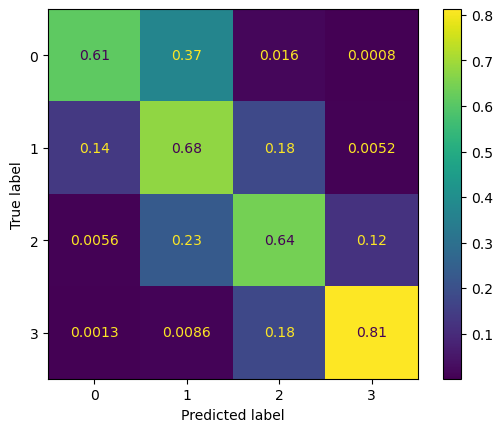

In [23]:
gc.collect()
# flat_preds = np.concatenate(svote_mask_final_bin).flatten()
# flat_truth = np.concatenate(final_labels_bin).flatten()
OUTPUT_CHANNELS = 4
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [ ]:
# Class   Damage
# 0	    <%5
# 1 	5%-20%
# 2	    20%-40%
# 3	    40%-60%
# 4	    60%-80%
# 5	    80%-100%

ARG